In [1]:
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
D:\Aconda\envs\RDSNet\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


(1000,)
(1000, 1)


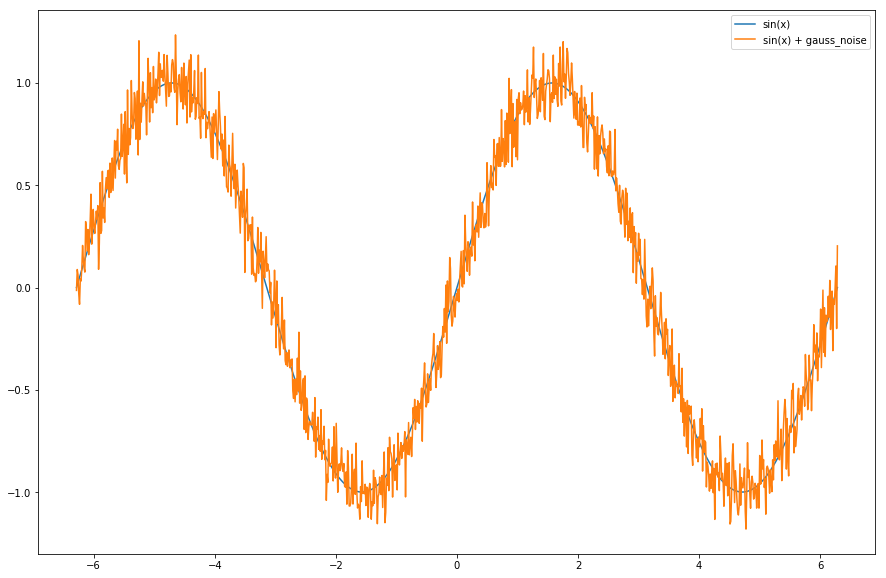

In [2]:
# 生成正弦函数数据集
x_train = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
y_sin = np.sin(x_train)

# 添加噪声
noise = np.random.normal(loc=0, scale=0.1, size=1000)
y_train = y_sin + noise
# y_train = y_sin
# 可视化数据
plt.figure(figsize=(15,10))
plt.plot(x_train, y_sin, label='sin(x)')
plt.plot(x_train, y_train, label='sin(x) + gauss_noise')
plt.legend()
# plt.show()
print(y_train.shape)
x_train = x_train.reshape(1000,1)
y_train = y_train.reshape(1000,1)
print(y_train.shape)

In [3]:
# x_test = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(1000,1)
# y_test = np.sin(x_test).reshape(1000,1)
# noise = np.random.normal(loc=0, scale=0.05, size=1000)
# y_test = y_test + noise

In [4]:
# 生成随机正弦函数数据集
x_test = np.random.uniform(low=-2 * np.pi, high=2 * np.pi, size=1000).reshape(1000,1)
y_test = np.sin(x_test).reshape(1000,1)

# 添加噪声
noise = np.random.normal(loc=0, scale=0.1, size=1000).reshape(1000,1)
y_test = y_test + noise

In [5]:
# -- 各种设置值 --
n_in = 1  # 输入层的神经元数量
n_mid = 10  # 中间层的神经元数量
n_out = 1  # 输出层的神经元数量

wb_width = 0.1  # 权重和偏置的分散度
eta = 0.005  # 学习系数
epoch = 5000
batch_size = 8
interval = 100  # 显示进度的时间间隔
n_train = 1000
n_test = 1000

In [6]:
# -- 各个网络层的祖先类 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)  # 权重（矩阵）
        self.b = wb_width * np.random.randn(n)  # 偏置（向量）

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# -- 中间层 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
#         self.y = sigmoid(self.u)
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)  # ReLU的微分
#         delta = grad_y * sigmoid(self.u) * (1 - sigmoid(self.u))
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)        
        self.grad_x = np.dot(delta, self.w.T)        # 反向传播

# -- 输出层 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u
#         self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)  # SoftMax函数

    def backward(self, t):
        delta = self.y - t        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)        
        self.grad_x = np.dot(delta, self.w.T)          # 反向传播

In [7]:
# -- 各个网络层的初始化 --
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 正向传播 ，一层一层的传播--
def forward_propagation(x):
    middle_layer_1.forward(x)
    middle_layer_2.forward(middle_layer_1.y)
    output_layer.forward(middle_layer_2.y)

# -- 逆向传播，一层一层传播 --
def backpropagation(t):
    output_layer.backward(t)
    middle_layer_2.backward(output_layer.grad_x)
    middle_layer_1.backward(middle_layer_2.grad_x)


In [8]:
# -- 权重和偏置的更新 --
def uppdate_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

# -- 计算误差 --
def get_error(t, batch_size):
    return np.mean((t - output_layer.y) ** 2) / batch_size
#     return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size  # 交叉熵误差


# -- 用于记录误差 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

In [ ]:
# -- 记录学习的过程和经过 --
n_batch = n_train // batch_size  # 每一轮epoch的批次尺寸
for i in range(epoch):

    # -- 误差的统计和测算 --  
    forward_propagation(x_train)    #调用forward_propagation函数
#     print(middle_layer_1.y.shape)
#     print(middle_layer_2.y.shape)
#     print(middle_layer_3.y.shape)
#     print(output_layer.y.shape)
    error_train = get_error(y_train, n_train)
    forward_propagation(x_test)
    error_test = get_error(x_test, n_test)
    
    # -- 误差的记录 -- 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    
    # -- 进度的显示 -- 
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))

    # -- 学习 -- 
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)  # 将索引值随机的打乱排序
    for j in range(n_batch):
        
        # 取出最小批次
#         print(x_train.shape)
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = x_train[mb_index, :]
        t = y_train[mb_index, :]
        
        # 正向传播和反向传播
        forward_propagation(x)
        backpropagation(t)
        
        # 权重和偏置的更新
        uppdate_wb()
    

Epoch:0/5000 Error_train:0.0005099904427875579 Error_test:0.013401367907849378
Epoch:100/5000 Error_train:1.720302368743844e-05 Error_test:0.01638831431798267
Epoch:200/5000 Error_train:1.525606643222065e-05 Error_test:0.016307281897955144
Epoch:300/5000 Error_train:1.1848375085962509e-05 Error_test:0.016033878151619364
Epoch:400/5000 Error_train:1.229790203750003e-05 Error_test:0.016274206193815827
Epoch:500/5000 Error_train:1.4793679230318028e-05 Error_test:0.016303148116021383
Epoch:600/5000 Error_train:1.189652852860107e-05 Error_test:0.016079604350963804
Epoch:700/5000 Error_train:1.655291748163799e-05 Error_test:0.016532693226725098
Epoch:800/5000 Error_train:1.1988146710104847e-05 Error_test:0.01613451830698233
Epoch:900/5000 Error_train:1.5417630860895717e-05 Error_test:0.016582859435521204
Epoch:1000/5000 Error_train:2.4819625093571998e-05 Error_test:0.016681942207394943
Epoch:1100/5000 Error_train:1.9674965968267616e-05 Error_test:0.015568727607983626
Epoch:1200/5000 Error_tr

In [ ]:
# -- 用图表表示误差的记录 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 测算正确率 -- 
forward_propagation(x_train)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(y_train, axis=1))

forward_propagation(x_test)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(y_test, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")

In [ ]:
plt.plot(x_train, y_train, label='sin(x)')
plt.plot(x_train, output_layer.y, label='sin(x) + gauss_noise')
plt.legend()
# plt.show()